In [1]:
from mitiq import benchmarks, MeasurementResult, zne, rem, pec, ddd
from qiskit import *
import networkx as nx
from qiskit_aer import *
import matplotlib.pyplot as plt
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from mitiq.rem import generate_inverse_confusion_matrix, execute_with_rem
# from mitiq.rem.inverse_confusion_matrix import mitigate_measurements
from itertools import product
from mitiq.observable.observable import Observable
from mitiq.observable.pauli import PauliString
from collections import defaultdict
from qiskit.circuit import Gate
import numpy as np
import time
import tomlkit
import toml
import functools
# import qiskit_aer.noise as noise

from mitiq.zne.inference import Factory, RichardsonFactory


In [1]:
class appBackend():
########################################################################################################################
#----------------------------------------------------------------------------------------------------------------------#
#                                          Execute-Related Functions                                                   #
#----------------------------------------------------------------------------------------------------------------------#
########################################################################################################################
    def execute(self, circuit, backend=AerSimulator(), shots=100, expected_bitstring='default_bs', path_to_metadata='default_path', tech = None, noise_model = None): 
        qc = circuit.copy()
        depth = qc.depth()
        ops_dict = qc.count_ops()
        qc.measure_all()

        gate_counts = {1: 0, 2: 0}
        for inst in circuit.data:
            if isinstance(inst.operation, Gate):
                qubit_count = len(inst.qubits)
                gate_counts[qubit_count] = gate_counts.get(qubit_count, 0) + 1

        transpiled_qc = transpile(qc, backend=backend, optimization_level=0)
        transpiled_depth = transpiled_qc.depth()

        if noise_model is not None:
            result = backend.run(transpiled_qc, noise_model=noise_model, shots=shots, optimization_level=0, memory = True).result()
        else:
            result = backend.run(transpiled_qc, shots=shots, optimization_level=0, memory = True ).result()
        
        msmt_counts = result.get_counts(qc)
        inverse_bs = expected_bitstring[::1]
        final_bitstring = ''.join(str(x) for x in inverse_bs)
        if msmt_counts.get(final_bitstring) is None:
            expectation_value = 0.
        else:
            expectation_value = msmt_counts.get(final_bitstring) / 100


        ###>------------------- Metadata part --------------------<###
        if tech == "None":
            return expectation_value
        else:
            self.makeMetadata(path_to_metadata, gate_counts, depth, transpiled_depth, msmt_counts, expectation_value, ops_dict)

        if tech == "REM":
            bitstrings = result.get_memory()
            print(bitstrings)
            rev_bitstrings = [bitstring[::-1] for bitstring in bitstrings]
            bitstrings_array = np.array([[int(bit) for bit in bitstring] for bitstring in rev_bitstrings])
            return MeasurementResult(bitstrings_array)
        # else:
        #     return expectation_value
    def executeREM(self, circuit, backend=AerSimulator(), shots=100, expected_bitstring=[0,1], path_to_metadata='default_path', tech = "REM", noise_model = None)-> MeasurementResult: 
            qc = circuit.copy()
            depth = qc.depth()
            ops_dict = qc.count_ops()
            qc.measure_all()

            gate_counts = {1: 0, 2: 0}
            for inst in circuit.data:
                if isinstance(inst.operation, Gate):
                    qubit_count = len(inst.qubits)
                    gate_counts[qubit_count] = gate_counts.get(qubit_count, 0) + 1

            transpiled_qc = transpile(qc, backend=backend, optimization_level=0)
            transpiled_depth = transpiled_qc.depth()

            if noise_model is not None:
                result = backend.run(transpiled_qc, noise_model=noise_model, shots=shots, optimization_level=0, memory = True).result()
            else:
                result = backend.run(transpiled_qc, shots=shots, optimization_level=0, memory = True ).result()
            
            msmt_counts = result.get_counts(qc)
            inverse_bs = expected_bitstring[::1]
            final_bitstring = ''.join(str(x) for x in inverse_bs)
            if msmt_counts.get(final_bitstring) is None:
                expectation_value = 0.
            else:
                expectation_value = msmt_counts.get(final_bitstring) / 100


            ###>------------------- Metadata part --------------------<###
            if tech == "None":
                return expectation_value
            else:
                self.makeMetadata(path_to_metadata, gate_counts, depth, transpiled_depth, msmt_counts, expectation_value, ops_dict)

            if tech == "REM":
                bitstrings = result.get_memory()
                print(bitstrings)
                rev_bitstrings = [bitstring[::-1] for bitstring in bitstrings]
                bitstrings_array = np.array([[int(bit) for bit in bitstring] for bitstring in rev_bitstrings])
                return MeasurementResult(bitstrings_array)
            # else:
            #     return expectation_value

    def batch_execute(self, circ_list, bs_list, technique_name, noisy=False, noise_model = None, backend=AerSimulator(), path_to_metadata='metadata.toml',shots=100, p_flip = .25):
        expectation_value = 0
        elapsed_time = 0
        if noisy or technique_name == 'REM': # REM always needs noisy
                # Load a basic noise model if none given
                if noise_model == None:
                     noise_model = self.basic_noise()
        else:
             noise_model = None

        for i,circ in enumerate(circ_list):
            self.initMetadata(path_to_metadata,i=i, technique_name=technique_name)

            start_time = time.time()  # Capture the start time
            # Logs the unmitigated expectation value
            unmitigated_expectation_value = self.execute(circuit=circ,noise_model=noise_model,
                        backend=backend, shots=shots,
                        expected_bitstring=bs_list[i],
                        path_to_metadata=path_to_metadata, tech = "None")
            
            end_time = time.time()  # Capture the end time
            unmitigated_elapsed_time = end_time - start_time  # Calculate the elapsed time

            # Make executor for mitiq executes
            new_executor = functools.partial(
                    self.execute,noise_model=noise_model,
                        backend=backend, shots=shots,
                        expected_bitstring=bs_list[i],
                        path_to_metadata=path_to_metadata, tech = technique_name)
            
            # Non_mitigated_expec = self.execute(circ, backend=backend, shots=shots, expected_bitstring=bs_list[i], path_to_metadata=path_to_metadata, noise_model = noise_model)
            if technique_name == 'REM':
                new_executor = functools.partial(
                    self.executeREM,noise_model=noise_model,
                        backend=backend, shots=shots,
                        expected_bitstring=bs_list[i],
                        path_to_metadata=path_to_metadata, tech = technique_name)
                # print(bs_list[i])
                self.addToMetadata(path_to_metadata, item = {"p_flip": p_flip})
                start_time = time.time()  # Capture the start time

                # MITIQ's REM error mitigation
                obs = self.pauli_strings_for_projection(bs_list[i])
                inverse_confusion_matrix = generate_inverse_confusion_matrix(len(bs_list[i]), p_flip, p_flip)
                msmt_counts_obj=rem.execute_with_rem(
                                        circ,
                                        new_executor,
                                        observable=obs,
                                        inverse_confusion_matrix=inverse_confusion_matrix,
                                        )
                
                end_time = time.time()  # Capture the end time
                elapsed_time = end_time - start_time  # Calculate the elapsed time

                msmt_counts = msmt_counts_obj.get_counts()
                inverse_bs = bs_list[i][::-1]
                final_bitstring = ''.join(str(x) for x in inverse_bs)
                if msmt_counts.get(final_bitstring) is None:
                    expectation_value = 0.
                else:
                    expectation_value = msmt_counts.get(final_bitstring) / 100
                    
            elif technique_name == 'ZNE':
                start_time = time.time()  # Capture the start time

                # MITIQ's Zero-Noise Extrapolation
                expectation_value = zne.execute_with_zne(circ, executor=new_executor)

                end_time = time.time()  # Capture the end time
                elapsed_time = end_time - start_time  # Calculate the elapsed time
            elif technique_name == 'PEC':

                start_time = time.time()  # Capture the start time

                # MITIQ's Probabilistic Error Cancellation
                reps = represent_operations_in_circuit_with_local_depolarizing_noise(circ, noise_level=0.025) 
                expectation_value = pec.execute_with_pec(circ, executor=new_executor, representations=reps, precision=0.5)
                
                end_time = time.time()  # Capture the end time
                elapsed_time = end_time - start_time  # Calculate the elapsed time 

            elif technique_name == 'DDD':
                start_time = time.time()  # Capture the start time
                
                # MITIQ's Digital Dynamical Decoupling
                rule = ddd.rules.xyxy
                expectation_value = ddd.execute_with_ddd(circuit=circ, executor=new_executor, rule=rule)

                end_time = time.time()  # Capture the end time
                elapsed_time = end_time - start_time  # Calculate the elapsed time
                

            self.addToMetadata(path_to_metadata, item = {f"unmitigated_elapsed_time": float(unmitigated_elapsed_time)})
            self.addToMetadata(path_to_metadata, item = {"unmitigated_expectation_value": unmitigated_expectation_value})
            # print(elapsed_time)
            # print(expectation_value)
            self.addToMetadata(path_to_metadata, item = {f"elapsed_time": float(elapsed_time)})
            self.addToMetadata(path_to_metadata, item = {"overall_expectation_value": float(expectation_value)})

########################################################################################################################
#----------------------------------------------------------------------------------------------------------------------#
#                                           Noise Model Functions                                                      #
#----------------------------------------------------------------------------------------------------------------------#
########################################################################################################################
    def basic_noise(self, prob_1=0.001, prob_2=0.01):

        # Error probabilitie: prob_1 => error prob for 1-qubit gates, prob_2 => error prob for 2-qubit gates

        # Depolarizing quantum errors
        error_1 = depolarizing_error(prob_1, 1)
        error_2 = depolarizing_error(prob_2, 2)

        # Readout errors (For REM implimentation)
        readout_error_0 = ReadoutError([[0.99, 0.01], [0.2, 0.8]])  # Example error for qubit 0
        readout_error_1 = ReadoutError([[0.85, 0.15], [0.1, 0.9]])  # Example error for qubit 1

        # Add errors to noise model
        noise_model = NoiseModel()
        noise_model.add_readout_error(readout_error_0, [0])
        noise_model.add_readout_error(readout_error_1, [1])
        noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
        noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

        return noise_model

    def depolarizing_noise(self, error1=0.005, error2=0.025):         # Default = 0.5% and 5% for 1qubit, 2qubit instructions             
        noise = NoiseModel()                                    # Initialize noise model

        error1 = depolarizing_error(error1, 1)                                 # Single qubit gate error
        error2 = depolarizing_error(error2, 2)                                 # 2 qubit gate error

        # Add single qubit gate errors
        noise.add_all_qubit_quantum_error(error1, ['rx', 'rz', 'id', 'sx'])    
        noise.add_all_qubit_quantum_error(error2, ['cx'])
            
        # sim_noise = AerSimulator(noise_model=noise)
        return noise

    def thermal_relaxation_noise_ionq(self, N, r_err = 0.005):       # Default readout error set to 0.5%, can change , N = num_qubits in circ                    
        
            # T1 and T2 values for qubits 0-N
            T1s = np.random.normal(1.1e10, 0.2e10, N)  # Sampled N values from normal dist, w/ mean = 1.1e10, std = 2e9 us, (converted to ns)
            T2s = np.random.normal(2e8, 0.2e8, N)      # Sampled N values from normal dist, w/ mean = 2e5, std = 2e4 us (converted to ns)

            # Instruction times (in nanoseconds)
            time_1 = 10000
            time_2 = 210000   

            noise_thermal = NoiseModel()               # Initialize noise model w ansatz gates
            noise_thermal.add_basis_gates(['rx', 'rz', 'cx'])

            # QuantumError objects
            errors_rx  = [thermal_relaxation_error(t1, t2, time_1)            # Make tuples of errors for rx, rz gates 
                        for t1, t2 in zip(T1s, T2s)]
            errors_rz  = [thermal_relaxation_error(t1, t2, time_1)
                        for t1, t2 in zip(T1s, T2s)]
            errors_sx  = [thermal_relaxation_error(t1, t2, time_1)
                        for t1, t2 in zip(T1s, T2s)]
            errors_id  = [thermal_relaxation_error(t1, t2, time_1)
                        for t1, t2 in zip(T1s, T2s)]
            errors_cx  = [thermal_relaxation_error(t1, t2, time_2).expand(thermal_relaxation_error(t1, t2, time_2))
                        for t1, t2 in zip(T1s, T2s) for t1, t2 in zip(T1s, T2s)]
            
            # Readout error:
            probs = ReadoutError([[1 - r_err, r_err], [r_err, 1 - r_err]])
            
            # Apply error to all qubits in circuit from randomly sampled parameters
            for j in range(N):
                noise_thermal.add_quantum_error(errors_rx[j], "rx", [j])
                noise_thermal.add_quantum_error(errors_rz[j], "rz", [j])
                noise_thermal.add_quantum_error(errors_sx[j], "sx", [j])
                noise_thermal.add_quantum_error(errors_id[j], "id", [j])
                noise_thermal.add_readout_error(probs, [j])
                for k in range(N):
                    noise_thermal.add_quantum_error(errors_cx[k], "cx", [j, k])

            # sim_noise = AerSimulator(noise_model=noise_thermal)
            return noise_thermal

########################################################################################################################
#----------------------------------------------------------------------------------------------------------------------#
#                                           Metadata-related Funcitons                                                 #
#----------------------------------------------------------------------------------------------------------------------#
########################################################################################################################
    def initMetadata(self, path_to_metadata, technique_name, i=0, new_flag= False, multi = False):
        if new_flag: # On first iteration
            # Create toml file type
            metadata = tomlkit.document()
            
            #Add an array that has zne in it called techniques
            metadata.add('techniques',[])
            #Write toml file as metadata.toml
            with open(path_to_metadata, 'w') as f:
                    toml.dump(metadata, f)
            return
            # metadata['techniques'].append("cir_" + str(i) + "_"+ technique_name) 
            # #Get the last technique in the techniques array
            # tech = str(metadata['techniques'][-1])
        else:
            with open(path_to_metadata, 'r') as f:
                    metadata = toml.load(f)
            #Add an array that has the lastest technique in it called techniques
            if not multi:
                metadata['techniques'].append(["cir_" + str(i) + "_" + technique_name]) 
                #Get the last technique in the techniques array
                tech = str(metadata['techniques'][-1])
                tech = str(tech).translate({ord(i): None for i in '[]\', '})
            else:
                #Get the last technique in the techniques array
                tech = "cir_" + str(i) + "_" + technique_name
                tech = str(tech).translate({ord(i): None for i in '[]\', '})
                 

        #Make a dictionary for cir_i_technique_name_
        metadata[tech]= tomlkit.table()

        # Add number of time run and make dictionary
        metadata[tech]["numRuns"] = 0
        metadata[tech][str(metadata[tech]["numRuns"])]= tomlkit.table()

        #Write toml file as metadata.toml
        with open(path_to_metadata, 'w') as f:
                toml.dump(metadata, f)
        return
    
    def makeMetadata(self, path_to_metadata, gate_counts, depth, transpiled_depth, msmt_counts, expectation_value, ops_dict):   
        with open(path_to_metadata, 'r') as f:
            metadata = toml.load(f) 
        # get lastest Technique (error mitigation implementation)
        tech = metadata['techniques'][-1]
        tech = str(tech).translate({ord(i): None for i in '[]\', '})

        # get current run count --> number of runs for current technique
        run_count = str(metadata[tech]["numRuns"])

        # # dictonary for the current circuit
        metadata[tech][run_count] = tomlkit.table()

        # dictonary for counts of 1 and 2 qubit gates
        metadata[tech][run_count]["1 and 2 qubit operator counts"] = tomlkit.table()

        # add current counts of 1 and 2 qubit gates
        for k, v in gate_counts.items():
            metadata[tech][run_count]["1 and 2 qubit operator counts"][str(k)  + " qubit gate operator(s)"] = int(v) 

        # add current circuit depth
        metadata[tech][run_count]['circuit depth'] = int(depth)

        # dictonary for the individual operator counts
        metadata[tech][run_count]['Individual operator counts'] = tomlkit.table()

        # add current individual operator counts
        for k, v in ops_dict.items():
            metadata[tech][run_count]['Individual operator counts'][str(k) + " gates"] = int(v) 

        # add current transpiled circuit depth
        metadata[tech][run_count]['Transpiled circuit depth'] = int(transpiled_depth)

        # dictonary for the Measurement Results
        metadata[tech][run_count]["Measurement Results"] = tomlkit.table()

        # add all current Measurement Results
        for k, v in msmt_counts.items():
            metadata[tech][run_count]["Measurement Results"][k.replace(" ","")] = int(v)+1-1 

        # add calculated expectation value --> frequency of correct_bitstring msmt
        metadata[tech][run_count]['expectation_value'] = float(expectation_value)

        # update run count for next circuit 
        metadata[tech]["numRuns"] = int(metadata[tech]["numRuns"]) + 1  

        with open(path_to_metadata, 'w') as f:
            toml.dump(metadata, f)
        return

    def addToMetadata(self, path_to_metadata, item = {"Nothing": None}):

        with open(path_to_metadata, 'r') as f:
            metadata = toml.load(f) 

        for key in item.keys():
            # get lastest Technique (error mitigation implementation)
            tech = metadata['techniques'][-1]
            tech = str(tech).translate({ord(i): None for i in '[]\', '})
            # get current run count --> number of runs for current technique
            metadata[tech][key] = item[key]
        
        with open(path_to_metadata, 'w') as f:
            toml.dump(metadata, f)
        return
  
    def getMetadataString(self, path_to_metadata):
        metadata = ""
        with open(path_to_metadata, 'r') as f:
            metadata = toml.load(f) 

        return metadata
    def summed(self, path_to_metadata, sums, arg):
        # Create toml file type
        sums = {arg:sums}
        metadata = tomlkit.loads(tomlkit.dumps(sums))
        metadata.add(tomlkit.nl())
        with open(path_to_metadata, 'a') as f:
            f.write(metadata.as_string())
         

########################################################################################################################
#----------------------------------------------------------------------------------------------------------------------#
#                                           Plotting-related Functions                                                 #
#----------------------------------------------------------------------------------------------------------------------#
########################################################################################################################
    def scale_for_plot(self, c_list, sums):
        add_params = {}

        og_params = self.get_original_circ_counts(c_list)
        add_params["depth"] = [x - y for x,y in zip(sums["circuit depth"], og_params["depth"])]
        add_params["1 qubit gates"] = [x-y for x,y in zip(sums["1 qubit gates"], og_params["1 qubit gates"])]
        add_params["2 qubit gates"] = [x-y for x,y in zip(sums["2 qubit gates"],og_params["2 qubit gates"])]

        return add_params
    
    def sumForPlot(self, path_to_metadata,tech ="ZNE"):
            sums = {} 
            with open(path_to_metadata, 'r') as f:
                    metadata = toml.load(f)
            numOfCirc = len(metadata['techniques'])
            
            
            sums["circuit depth"] = [0 for x in range(numOfCirc)]
            sums["Transpiled circuit depth"] = [0 for x in range(numOfCirc)]
            sums["1 qubit gates"] = [0 for x in range(numOfCirc)]
            sums["2 qubit gates"] = [0 for x in range(numOfCirc)]
            sums[f"{tech}_overall_expectation_value"] = [0 for x in range(numOfCirc)]
            sums[f"{tech}_unmitigated_expectation_value"] = [0 for x in range(numOfCirc)]
            sums[f"{tech}_elapsed_time"] = [0 for x in range(numOfCirc)]
            sums[f"{tech}_unmitigated_elapsed_time"] = [0 for x in range(numOfCirc)]

            # print("Summarizing " + path_to_metadata[:-5] + " information.........")

            for k in range(numOfCirc): 
                    currentCirc = metadata["cir_" + str(k) + "_"+ tech]
                    for i in range(currentCirc["numRuns"]):
                            sums["circuit depth"][k] += int(currentCirc[str(i)]["circuit depth"])
                            sums["Transpiled circuit depth"][k] += int(currentCirc[str(i)]["Transpiled circuit depth"])
                            sums["1 qubit gates"][k] += int(currentCirc[str(i)]["1 and 2 qubit operator counts"]["1 qubit gate operator(s)"])  
                            sums["2 qubit gates"][k] += int(currentCirc[str(i)]["1 and 2 qubit operator counts"]["2 qubit gate operator(s)"])
                    sums[f"{tech}_overall_expectation_value"][k] = metadata[f"cir_{k}_{tech}"]["overall_expectation_value"]
                    sums[f"{tech}_unmitigated_expectation_value"][k] = metadata[f"cir_{k}_{tech}"]["unmitigated_expectation_value"]
                    sums[f"{tech}_unmitigated_elapsed_time"][k] = metadata[f"cir_{k}_{tech}"]["unmitigated_elapsed_time"]
                    sums[f"{tech}_elapsed_time"][k] = metadata[f"cir_{k}_{tech}"]["elapsed_time"]

            return sums

    def start(self, tech,  path_to_metadata = "metadata.toml", overheads = ["None"], circuitInfo = None ,noisy=False, p_flip =.25, noise_model = None, gui = False, max_qbits=4, plotSize = (7,4)):      
        if circuitInfo == None:
             circuitInfo = self.get_circ_bs_lists(max_qbits)
          
        # print(f"tech = {tech}")
        if tech == "Zero-Noise Extrapolation":
            tech = "ZNE"
        elif tech == "Digital Dynamical Decoupling":
            tech = "DDD"
        elif tech == "Readout error Mitigation":
            tech = "REM"
        elif tech == "Probabilistic Error Cancellation":
            tech = "PEC"

        circs, bss, qbit_count_arr = circuitInfo

        self.initMetadata(path_to_metadata, tech, new_flag=True)
        self.batch_execute(circ_list=circs, bs_list=bss, technique_name=tech, path_to_metadata=path_to_metadata, noisy=noisy, p_flip=p_flip,noise_model=noise_model)

        if gui:
            return self.plot_it(tech=tech,  circuitInfo=circuitInfo, plotSize = plotSize, overheads = overheads, path_to_metadata = path_to_metadata)
    
    def plot_it(self, tech, circuitInfo, plotSize, path_to_metadata = "metadata.toml",overheads = ["None"], arg = "Default", graph = (None,None)):      

        circs, _ , qbit_count_arr = circuitInfo

        if graph == (None,None):
            fig, ax = plt.subplots(figsize=plotSize)
        else:
            fig,ax = graph
        
        sums = self.sumForPlot(path_to_metadata=path_to_metadata, tech=tech)
        appBackend().summed(path_to_metadata= f"summary_{tech}.toml",sums=sums, arg=arg)

        mE_value = sums[f"{tech}_overall_expectation_value"]
        uE_value = sums[f"{tech}_unmitigated_expectation_value"]
        time = sums[f"{tech}_elapsed_time"]
        um_time = sums[f"{tech}_unmitigated_elapsed_time"]
        
        add_params = self.scale_for_plot(circs, sums)
        ax.set_xlabel(r'$N_{qubits}$')
        ax.set_ylabel('Time')
        
        # print(np.array(time)-np.array(um_time))
        for overhead in overheads:
            if overhead == "Circuit Depth":
                c = ax.plot(qbit_count_arr, add_params["depth"], '.-', color="mediumseagreen", label='Additional Depth')

            if overhead == "Number of Single Qubit Gates":
                n = ax.plot(qbit_count_arr, add_params["1 qubit gates"], '.-', color="orange", label='# Added Single Qubit Gates')
            if overhead == "Number of Two Qubit Gates":
                t  = ax.plot(qbit_count_arr, add_params["2 qubit gates"], '.-', color="blue", label='# Added Two Qubit Gates')
            if overhead == "Time":
                c = ax.plot(qbit_count_arr, um_time, '.-', color="red", label='unmitigated')
                g = ax.plot(qbit_count_arr, time, '.-', color="black", label='mitigated')
        # n = ax.plot(arr, add_params["1 qubit gates"], '.-', color="dodgerblue", label='# Added Single Qubit Gates')
        # Ensure that at least one plot element has a label before calling legend
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend()
        return fig,ax
    

########################################################################################################################
#----------------------------------------------------------------------------------------------------------------------#
#                                             Miscellaneous Functions                                                  #
#----------------------------------------------------------------------------------------------------------------------#
########################################################################################################################

    def get_circuit_and_bs(self, layer_depth, n_qubits, seed=None):
        circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
            nlayers=layer_depth,
            two_qubit_gate_prob=1.0,
            connectivity_graph=nx.complete_graph(n_qubits),
            two_qubit_gate_name="CNOT",
            seed=seed,
            return_type="qiskit",
        )        
        return circuit, correct_bitstring
    
    def get_circ_bs_lists(self, max_qbits):
        qbit_count_arr = np.arange(1,max_qbits+1,1)
        c_list = []
        b_list = []

        for k in qbit_count_arr:
            c, b = self.get_circuit_and_bs(20,k)
            c_list.append(c)
            b_list.append(b)

        return c_list, b_list, qbit_count_arr
    
    def get_original_circ_counts(self, c_list):
        og_params = {}

        og_params["depth"] = [0 for x in range(len(c_list))]
        og_params["1 qubit gates"] = [0 for x in range(len(c_list))]
        og_params["2 qubit gates"] = [0 for x in range(len(c_list))]

        for k in range(len(c_list)):
            og_params["depth"][k] = c_list[k].depth()
            counts = defaultdict(int)

            for inst in c_list[k].data:
                if isinstance(inst.operation, Gate):
                    counts[len(inst.qubits)] += 1
                
                o = {k: v for k, v in counts.items()}
                        
                single_qubit_gates = (o.get(1)) if o.get(1) is not None else 0
                two_qubit_gates = (o.get(2)) if o.get(2) is not None else 0
                
                og_params["1 qubit gates"][k] = single_qubit_gates
                og_params["2 qubit gates"][k] = two_qubit_gates 

        return og_params

    def pauli_strings_for_projection(self, bitstring):
            n = len(bitstring)
            pauli_terms = []
            # Iterate over all possible combinations of 'I' and 'Z' for the length of the bitstring
            for pauli_tuple in product('IZ', repeat=n):
                pauli_string = ''.join(pauli_tuple)
                coeff = 1 / (2 ** n)
                for index, value in enumerate(bitstring):
                    if value == 1 and pauli_string[index] == 'Z':
                        coeff *= -1
                # print(f'pauli_term: {pauli_string}, coeff: {coeff}')
                pauli_terms.append(PauliString(pauli_string, coeff))
            return Observable(*pauli_terms)

NameError: name 'AerSimulator' is not defined

In [22]:
# # # This is to run parameters for the batch

p_flips = [0.05] # this is the parameter for REM
tech ="REM"
circuitTypes = "mirrorCircuits"
numQubits = 4
graph = (None,None)
b = appBackend()
circuitInfo = b.get_circ_bs_lists(max_qbits=numQubits)

#Clears old summary file of the tech
metadata = tomlkit.document()
metadata.add(tomlkit.comment(f"This is a summary of {tech} using {circuitTypes} with {numQubits} qubits"))
metadata.add(tomlkit.comment(f"Varing p flips: {p_flips}\n"))

with open(f"summary_{tech}.toml", 'w') as f:
    f.write(metadata.as_string())
b = appBackend()

for i,p_flip in enumerate(p_flips):
    filename = f"metadata_{tech}_{p_flip}.toml"
    b.start(tech=tech, circuitInfo=circuitInfo, p_flip=p_flip, path_to_metadata=filename, noise_model=appBackend().thermal_relaxation_noise_ionq(numQubits,.05))
    graph = b.plot_it(tech=tech, circuitInfo=circuitInfo, path_to_metadata=filename, plotSize = (7,4),  arg=f"p_flip_{p_flip}", graph = graph)



tech = REM
[1]
pauli_term: I, coeff: 0.5
pauli_term: Z, coeff: -0.5
['1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 0', '0 1', '1 1', '1 1', '1 1', '1 1', '0 1', '1 1', '1 0', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 0', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '0 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1', '1 1']


ValueError: invalid literal for int() with base 10: ' '

In [2]:
# Change jupyter of the executor_func_gui into a python script
# error_Comparison_Gui must be a script to be able to import
# !jupyter nbconvert --to python error_Comparison_Gui.ipynb 

[NbConvertApp] Converting notebook error_Comparison_Gui.ipynb to python
[NbConvertApp] Writing 14295 bytes to error_Comparison_Gui.py


In [46]:
# for i in range(1,11):
#     start_time = time.time()  # Capture the start time
#     generate_inverse_confusion_matrix(i, .2, .2)
#     end_time = time.time()  # Capture the end time
#     elapsed_time = end_time - start_time  # Calculate the elapsed time
#     print(f"{i} elapsed_time:{elapsed_time}")
                

1 elapsed_time:0.0010001659393310547
2 elapsed_time:0.0
3 elapsed_time:0.0
4 elapsed_time:0.0
5 elapsed_time:0.0
6 elapsed_time:0.0
7 elapsed_time:0.0010013580322265625
8 elapsed_time:0.0019989013671875
9 elapsed_time:0.006522417068481445
10 elapsed_time:0.03166627883911133


tech = ZNE
0.4840247631072998
0.9399999999999992
0.3857274055480957
1.0699999999999994
0.5961520671844482
0.9299999999999984
0.5092582702636719
0.0
Summarizing metadata information.........
[0.44524455 0.31250215 0.51563859 0.42774487]


(<Figure size 700x400 with 1 Axes>,
 <Axes: xlabel='$N_{qubits}$', ylabel='Time'>)

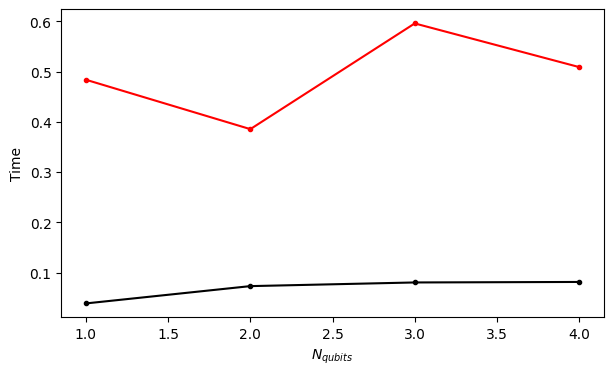

In [6]:
# circuitInfo = b.get_circ_bs_lists(max_qbits=4)
# tech="ZNE"
# #Clears old summary file of the tech
# metadata = tomlkit.document()
# with open(f"summary_{tech}.toml", 'w') as f:
#     f.write(metadata.as_string())
# appBackend().start(tech=tech, circuitInfo=circuitInfo,noisy=True,  noise_model=appBackend().thermal_relaxation_noise_ionq(numQubits))
# appBackend().plot_it(tech=tech, circuitInfo=circuitInfo,path_to_metadata = "metadata.toml", plotSize = (7,4))